In [10]:
import numpy as np 
import pandas as pd 
import pandas_datareader as pdr 
import matplotlib.pyplot as plt 
import datetime
import yfinance as yf

In [39]:
gld = yf.download("GLD", start="2016-01-01", end="2025-07-24")
gld.columns = gld.columns.get_level_values(0)
day = np.arange(1, len(gld) + 1)

[*********************100%***********************]  1 of 1 completed


In [40]:
gld['day'] = day
gld.drop(columns=["Volume"], inplace=True)
gld.head()

Price,Close,High,Low,Open,day
Date,,,,,
2016-01-04,102.889999,103.669998,102.489998,103.129997,1
2016-01-05,103.180000,103.459999,102.930000,103.129997,2
2016-01-06,104.669998,104.800003,103.930000,104.370003,3
2016-01-07,106.150002,106.239998,105.190002,105.830002,4
2016-01-08,105.680000,105.800003,105.040001,105.480003,5


In [41]:
gld = gld[["Close", "High", "day", "Open", "Low"]]

In [42]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2402 entries, 2016-01-04 to 2025-07-23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2402 non-null   float64
 1   High    2402 non-null   float64
 2   day     2402 non-null   int64  
 3   Open    2402 non-null   float64
 4   Low     2402 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 112.6 KB


## Add data/transform data
- calculate signal based on some price or statistical action
- we are going to try moving average crossover to generate signals
- for this strategy we will always by in a trade, either "long" or "short"
- we are modeling, this means real life variation should be expected

## Add moving averages to the data frame

In [105]:
gld["9-days"] = gld["Close"].rolling(window=9).mean().shift(1)
gld["21-days"] = gld["Close"].rolling(window=21).mean().shift(1)
#We use shift(1) because now the '9-days' moving average is a real moving average lagged, this means 
# the moving average at date t only uses the previous '9-days' closing prices, ending at date t-1.
# the value is something a trader could have known at the beginning of day t, before any new price movement 
#At time t, the moving average is based only on data up to t-1 (past information).
#So the value could have been known at the beginning of day t.

- '9-days' moving-average is a short term average of closing prices over the past 9 trading days.
It is more responsive to recent price changes.

- '21-days' is a long term average of the last 21 trading days.
It reacts more slowly and captures the broader trend.

In [104]:
gld[7:]


Price,Close,High,day,Open,Low,9-days,21-days,signal,return,system_return,entry
Date,,,,,,,,,,,
2016-02-12,118.360001,118.739998,29,118.120003,117.879997,NaN,NaN,1,-0.005897,-0.005897,0.0
2016-02-16,114.769997,116.309998,30,116.000000,114.739998,NaN,NaN,1,-0.030801,-0.030801,0.0
2016-02-17,115.480003,116.070000,31,115.470001,114.889999,114.022222,NaN,1,0.006167,0.006167,0.0
2016-02-18,118.290001,118.599998,32,115.300003,115.290001,114.714444,NaN,1,0.024042,0.024042,0.0
2016-02-19,117.580002,117.970001,33,117.260002,117.099998,115.572222,NaN,1,-0.006020,-0.006020,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-17,307.589996,307.670013,2398,305.500000,305.119995,306.947784,307.650478,-1,-0.002176,0.002176,0.0
2025-07-18,308.390015,309.369995,2399,309.239990,308.320007,306.997782,307.450954,-1,0.002598,-0.002598,0.0
2025-07-21,313.130005,313.309998,2400,311.880005,311.609985,307.111118,307.281907,-1,0.015253,-0.015253,0.0


## add signal column

In [60]:
gld["signal"] = np.where(gld["9-days"] > gld["21-days"], 1, 0)
gld["signal"] = np.where(gld["9-days"] < gld["21-days"], -1, gld["signal"])
gld.dropna(inplace=True)

In [61]:
gld.head()

Price,Close,High,day,Open,Low,9-days,21-days,signal
Date,,,,,,,,
2016-02-03,109.250000,109.580002,22,107.910004,107.900002,106.797778,105.422381,1
2016-02-04,110.570000,110.699997,23,110.449997,109.919998,107.215556,105.725238,1
2016-02-05,112.320000,112.349998,24,109.790001,109.580002,107.834445,106.077143,1
2016-02-08,113.830002,114.870003,25,113.669998,113.389999,108.527778,106.441429,1
2016-02-09,113.580002,114.690002,26,114.430000,113.550003,109.254445,106.807143,1


## Calculate instantaneous returns / system returns

In [106]:
gld["return"] = np.log(gld["Close"]).diff() #we take the log returns
gld["entry"] = gld.signal.diff() #this column contains trading signals 
# +1 for 'buy', -1 for 'sell', 0 for 'no position'
gld["system_return"] = gld["signal"] * gld["return"]
#this column tracks your strategy's performance

## Plot trades on time series

In [107]:
gld_last = gld.iloc[-252:]
mask = gld_last["entry"]==2 
dates = gld_last.index[mask] 
ma9 = gld_last.loc[mask, '9-days']

mask_2 = gld_last["entry"]==-2 
dates_2 = gld_last.index[mask_2]
ma21 = gld_last.loc[dates_2, '21-days']


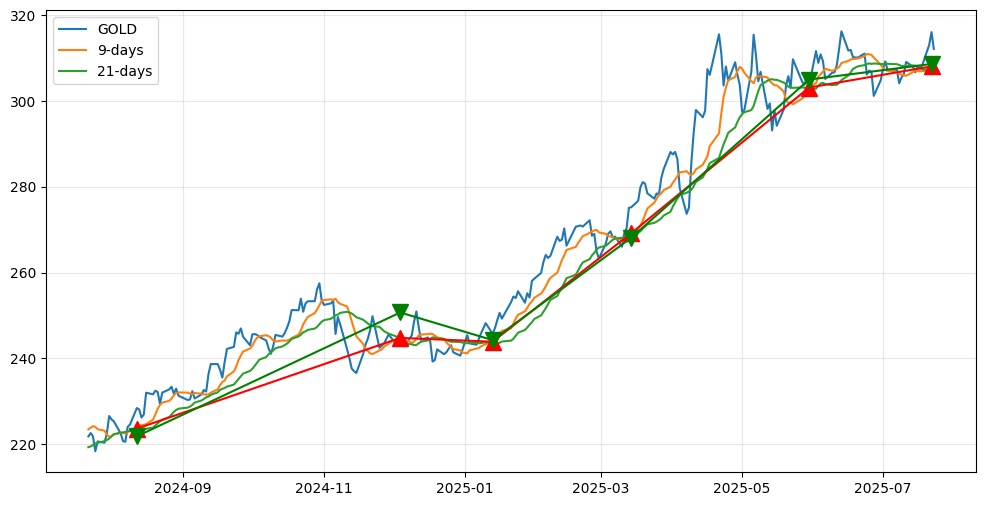

In [108]:
plt.rcParams['figure.figsize']=12,6
plt.grid(True, alpha=.3)
plt.plot(gld.iloc[-252:]["Close"], label="GOLD")
plt.plot(gld.iloc[-252:]["9-days"], label="9-days")
plt.plot(gld.iloc[-252:]["21-days"], label="21-days")
plt.plot(dates, ma9, marker='^', color='r' ,markersize=12)
plt.plot(dates, ma21, marker='v', color='g' ,markersize=12)

plt.legend()

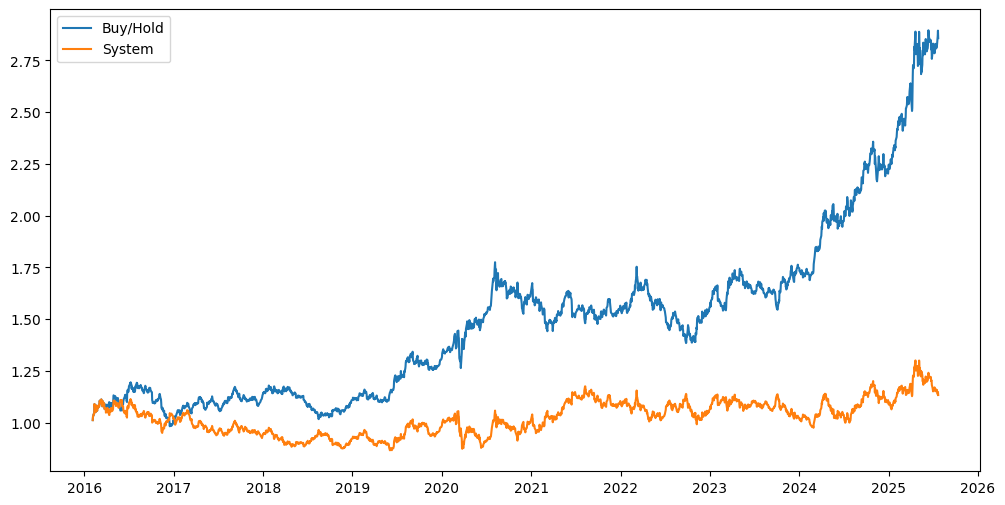

In [89]:
plt.plot(np.exp(gld["return"]).cumprod(), label="Buy/Hold")
#we use the np.exp command to convert log returns back to percentage returns and we do "cumprod" to get the cumulative product
#for knowing how our capital growns over time
plt.plot(np.exp(gld["system_return"]).cumprod(),label="System")
# this does the same but using only the returns when your signal is active 
#it shows how well your strategy performs compared to just buying an asset and holding it.
plt.legend()

In [111]:
np.exp(gld["return"].cumprod())[-1] -1

/var/folders/gg/dm5j6jg565j0bblwgpt9ggsw0000gn/T/ipykernel_68705/2368563050.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(gld["return"].cumprod())[-1] -1


0.0

In [115]:
np.exp(gld["system_return"].cumprod())[-1] -1

/var/folders/gg/dm5j6jg565j0bblwgpt9ggsw0000gn/T/ipykernel_68705/2933006432.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(gld["system_return"].cumprod())[-1] -1


0.0